# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [130]:
from scipy.stats import kurtosis

n_samples = 10000

In [131]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [132]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

/tmp/ipython-input-2994955598.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()
[*********************100%***********************]  51 of 51 completed


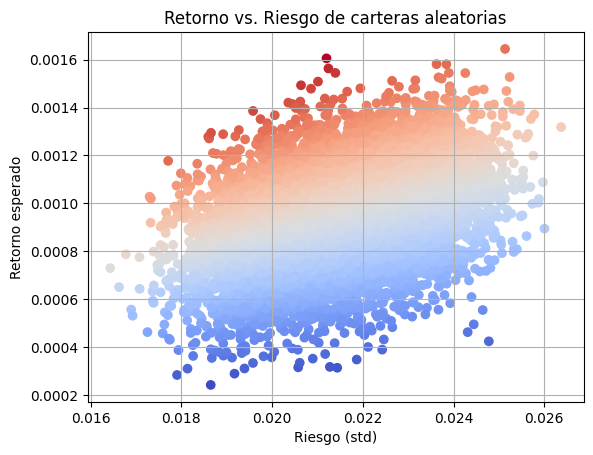

In [133]:

returns = get_data(csv=False)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'YINN', 'BNTX', 'BOIL', 'WULF', 'UVIX', 'FNGU', 'SAVA', 'GME', 'PATH', 'TQQQ', 'UPRO', 'SNOW', 'XOP', 'VKTX', 'FCX', 'AMC', 'LCID', 'SOXL', 'AI', 'ILMN', 'RIVN'}
[50, 5, 6, 47, 45, 14, 33, 16, 27, 39, 43, 35, 49, 46, 13, 2, 22, 36, 0, 18, 32]


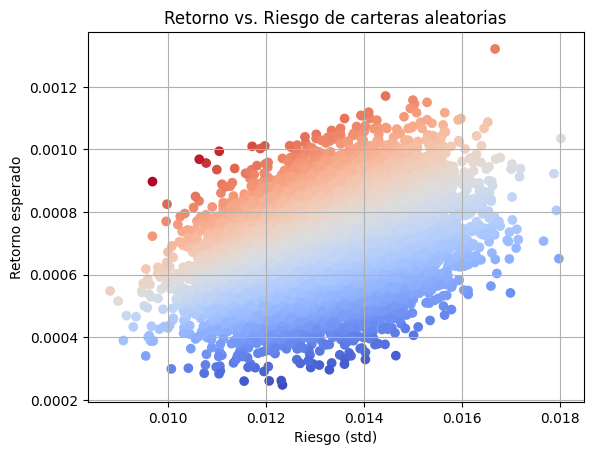

In [134]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 6):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.85) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [135]:
import cvxpy as cp

# Los assets con correlacion inferior al 85% y curtosis < 6 y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

min_expected_ret_daily = returns_means.min()
max_expected_ret_daily = returns_means.max() * 0.6

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 0.08, # No invertimos mas de un 8% en cada activo
    best_weights[-1] <= 0.1, # El activo de renta fija debe pesar como mucho un 10%
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados
]

results = []
rf_daily = 0.2/252
for r_target in np.linspace(min_expected_ret_daily, max_expected_ret_daily, 200):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)

    problem.solve()

    if best_weights.value is not None:
        ret = portfolio_returns.value
        vol = np.sqrt(portfolio_variance.value)
        sharpe_ratio = (ret - rf_daily) / vol if vol > 0 else 0
        row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])
        results.append(row)

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)
portfolio_results

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,...,asset42,asset43,asset44,asset45,asset46,asset47,asset48,asset49,asset50,Renta Fija
160,0.002650,0.018777,0.098879,-1.251690e-08,8.000456e-02,-1.210467e-08,4.766184e-02,0.079996,-4.934661e-09,-1.234807e-08,...,-8.145231e-06,-2.976004e-09,-9.818433e-06,-4.057542e-09,-1.560440e-09,8.968624e-09,0.080003,-4.857230e-09,2.602726e-10,0.099996
161,0.002693,0.019226,0.098809,-6.675100e-09,7.999732e-02,-7.743375e-09,4.236035e-02,0.079994,-5.786631e-09,-8.710963e-09,...,-7.577174e-06,-3.325299e-09,-5.376932e-06,-1.229325e-08,-3.560624e-09,1.224840e-09,0.079997,-5.576783e-09,-2.451884e-09,0.087856
159,0.002607,0.018365,0.098760,1.708883e-09,7.999880e-02,1.305828e-09,5.927507e-02,0.080000,2.752767e-10,1.707258e-09,...,7.793502e-07,8.794407e-12,1.325996e-06,-9.907255e-10,-1.166797e-10,-2.127840e-09,0.079999,2.600118e-10,-1.361665e-10,0.099999
162,0.002736,0.019681,0.098714,-8.489419e-10,8.000082e-02,-1.131847e-09,4.572150e-02,0.079999,-3.820114e-10,-9.874659e-10,...,-8.312183e-07,3.637794e-11,-3.855670e-07,-1.769477e-09,1.827707e-10,4.262572e-10,0.080000,-4.541947e-10,-1.330542e-11,0.070502
163,0.002779,0.020138,0.098605,4.843622e-10,8.000378e-02,6.603878e-10,5.008593e-02,0.080002,1.722928e-09,5.370497e-10,...,1.429207e-06,2.184439e-09,1.210028e-06,2.201799e-09,2.394769e-09,3.997270e-09,0.080003,1.853122e-09,2.139910e-09,0.053072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.000291,0.009894,-0.050771,-3.609564e-11,1.200235e-07,-1.484188e-11,7.824894e-08,0.080000,3.008882e-11,5.386682e-12,...,8.000001e-02,2.719555e-11,-4.422553e-08,1.404529e-10,3.821416e-11,1.244609e-10,0.080000,3.551889e-11,2.829670e-11,0.100000
78,0.000291,0.009894,-0.050771,-3.609564e-11,1.200235e-07,-1.484188e-11,7.824894e-08,0.080000,3.008882e-11,5.386682e-12,...,8.000001e-02,2.719555e-11,-4.422553e-08,1.404529e-10,3.821416e-11,1.244609e-10,0.080000,3.551889e-11,2.829670e-11,0.100000
79,0.000291,0.009894,-0.050771,-3.609564e-11,1.200235e-07,-1.484188e-11,7.824894e-08,0.080000,3.008882e-11,5.386682e-12,...,8.000001e-02,2.719555e-11,-4.422553e-08,1.404529e-10,3.821416e-11,1.244609e-10,0.080000,3.551889e-11,2.829670e-11,0.100000
101,0.000291,0.009894,-0.050771,-2.341149e-11,2.712034e-08,-8.874422e-12,-3.959542e-08,0.080000,1.003868e-11,7.699253e-12,...,8.000002e-02,-4.782931e-12,-5.064950e-08,1.087707e-10,1.584653e-11,2.929381e-11,0.080000,1.296863e-11,3.803071e-12,0.100000


In [136]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [137]:
rounded_weights = round_weights(portfolio_results.iloc[0, 3:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(len(rounded_weights[rounded_weights > 0]))

['0', '0.081', '0', '0.047', '0.079', '0', '0', '0', '0', '0', '0', '0.08', '0', '0', '0', '0.081', '0', '0.08', '0', '0', '0', '0.081', '0', '0', '0', '0', '0', '0', '0', '0.066', '0', '0.034', '0', '0', '0.079', '0', '0', '0.081', '0', '0', '0', '0.031', '0', '0', '0', '0', '0', '0', '0.081', '0', '0', '0.099']
14


In [138]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.000079

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)

Downside Deviation: 0.019335174980348077


In [140]:
import numpy as np

# 1. Calcula los retornos diarios de tu cartera
portfolio_daily_returns = returns @ rounded_weights[:-1] + (rounded_weights[-1] * (0.02/252))

# 2. Calcula el valor acumulado de la inversión (empezando desde 1)
wealth_index = (1 + portfolio_daily_returns).cumprod()

# 3. Calcula el pico máximo acumulado en cada momento
previous_peaks = wealth_index.cummax()

# 4. Calcula los drawdowns
drawdowns = (wealth_index - previous_peaks) / previous_peaks

# 5. El Max Drawdown es el valor mínimo (la caída más profunda)
mdd = drawdowns.min()

print(f"Max Drawdown: {mdd * 100:.2f}%")

Max Drawdown: -21.41%
